In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
from sklearn.utils import shuffle
import random
from skimage import draw
import pandas as pd

from PIL import Image

import seaborn as sns


class MyModel(object):
    miu_0 = 4 * np.pi * (1e-7)  # μ0为真空磁导率

    def __init__(self, map_length=25, zmax=100, a=0.4, b=0.1, c=0.1,
                 gama=90.0, theta=0.0, phi=-5.0, x=0, y=0, z=1.5, b_0=55000.0, I=70.0, D=3.5) -> None:

        self.map_length = map_length
        self.zmax = zmax
        self.X = np.linspace(-map_length, map_length, zmax)  # 0,1,...x
        self.Y = np.linspace(-map_length, map_length, zmax)
        self.center = [x, y, z]  # 中心点坐标
        self.axis = [a, b, c]  # 三个轴长 a> b > c
        self.D = np.radians(D)  # 磁偏角
        self.I = np.radians(I)  # 磁倾角
        # self.I = np.arctan(2*np.tan(np.radians(I)))  # 磁倾角
        self.b_0 = b_0
        self.B_0 = self.__dicichang()

        if b == c:
            self.axis = [a, b, b]
            self.e = a/b  # 横纵轴比
        # 椭球的方向
        self.gama = gama
        self.theta = theta
        self.phi = phi
        # 转为rad值
        self.gama_rad = np.radians(self.gama)
        self.theta_rad = np.radians(self.theta)
        self.phi_rad = np.radians(self.phi)

        self.V = self.__volme()  # 体积
        self.A = self.__euler_angles()  # 欧拉旋转角
        self.X_d = self.__effective_permeability_matrix()  # 计算有效磁化率矩阵
        self.m_i = self.__total_magnetic_dipole_moment()  # 总磁偶极矩
        self.F = self.__ji_suan_yi_chang()

    # 计算体积

    def __volme(self):
        return 4/3*np.pi*self.axis[0]*self.axis[1]*self.axis[2]

    # 计算地磁场
    def __dicichang(self):
        b0 = self.b_0 * np.array([np.cos(self.I)*np.cos(self.D),
                                 np.cos(self.I)*np.sin(self.D), np.sin(self.I)])
        return b0
    # 计算欧拉旋转角

    def __euler_angles(self):
        A = np.array([
            [np.cos(self.gama_rad) * np.cos(self.phi_rad), -np.cos(self.gama_rad)
             * np.sin(self.phi_rad), -np.sin(self.gama_rad)],
            [np.sin(self.theta_rad) * np.sin(self.gama_rad) * np.cos(self.phi_rad) + np.cos(self.theta_rad) * np.sin(self.phi_rad),
             -np.sin(self.theta_rad) * np.sin(self.gama_rad) *
             np.sin(self.phi_rad) + np.cos(self.theta_rad) *
             np.sin(self.phi_rad),
             np.sin(self.theta_rad) * np.cos(self.gama_rad)],
            [np.cos(self.theta_rad) * np.sin(self.gama_rad) * np.cos(self.phi_rad) - np.sin(self.theta_rad) * np.sin(self.phi_rad),
             -np.cos(self.theta_rad) * np.sin(self.gama_rad) *
             np.sin(self.phi_rad) - np.sin(self.theta_rad) *
             np.cos(self.gama_rad),
             np.cos(self.theta_rad) * np.cos(self.gama_rad)]
        ])
        return A

    # 计算有效磁化率矩阵
    def __effective_permeability_matrix(self):
        E = np.log(self.e - np.sqrt(self.e**2 - 1)) / np.sqrt(self.e**2 - 1)
        alpha_1 = (self.e * (self.e + E)) / (self.e**2 - 1)
        alpha_3 = (-2 * self.e * (self.e**(-1) + E)) / (self.e**2 - 1)
        alpha_2 = (self.e * (self.e + E)) / (self.e**2 - 1)
        v = [2/alpha_1, 2/alpha_2, 2/alpha_3]
        X_d = np.diag(v)
        return X_d

    # 计算总磁偶极矩

    def __total_magnetic_dipole_moment(self):
        m_i = (self.V/MyModel.miu_0)*self.A.T @ self.X_d @ self.A @ self.B_0

        return m_i

    def __ji_suan_yi_chang(self):
        X = self.X
        Y = self.Y
        miu_0 = MyModel.miu_0
        m_i = self.m_i
        I = self.I
        D = self.D
        Z = 0
        x_0, y_0, z_0 = self.center
        X_0, Y_0 = np.meshgrid(X, Y)
        igrf = np.array([np.cos(I)*np.cos(D), np.cos(I) *
                        np.sin(D), np.sin(I)], dtype=float)
        self.igrf = igrf
        temp1 = np.empty_like(X_0, dtype=float)
        temp2 = np.empty_like(X_0, dtype=float)
        temp3 = np.empty_like(X_0, dtype=float)
        temp4 = np.empty_like(X_0, dtype=object)
        temp5 = np.empty_like(X_0, dtype=object)
        b = np.empty_like(X_0, dtype=object)
        F1 = np.empty_like(X_0, dtype=float)
        for i in range(X_0.shape[0]):
            for j in range(Y_0.shape[1]):
                R = np.array([X_0[i, j] - x_0, Y_0[i, j] -
                             y_0, Z - z_0], dtype=float)
                RR = np.linalg.norm(R)
                temp1[i, j] = miu_0 / (4 * np.pi * RR ** 3)
                temp2[i, j] = 3 / RR ** 2
                temp3[i, j] = np.dot(R, m_i)
                temp4[i, j] = temp3[i, j] * R
                temp5[i, j] = temp2[i, j] * temp4[i, j] - m_i
                b[i, j] = temp1[i, j] * temp5[i, j]

                F1[i, j] = b[i, j] @ igrf.T

        return F1


In [10]:
test=MyModel(a=1)

In [6]:
map_lenght=25
zmax=100

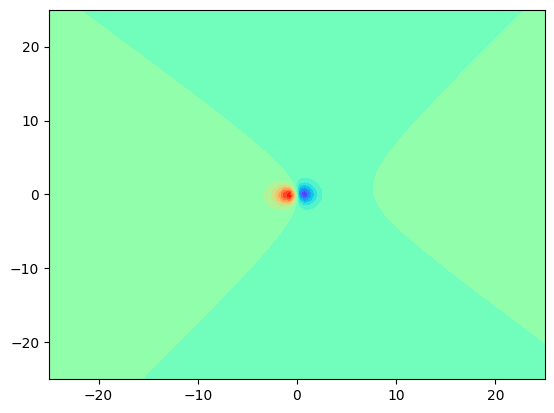

In [11]:
X = np.linspace(-map_lenght, map_lenght, zmax)
Y = np.linspace(-map_lenght, map_lenght, zmax)


plt.contourf(X, Y, test.F, levels=16, cmap='rainbow')